In [1]:
# Imports
import os
from pathlib import Path
import numpy as np
from rushlight.utils.lso_align import calc_vect
from sunpy.map import Map

import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.map
from sunpy.coordinates import frames

import pickle

In [2]:
# Import dotenv
from dotenv import load_dotenv
load_dotenv()

False

In [3]:
# Load AIA image, 
aia_193_imag = Map('./observations/aia.lev1.193A_2012-07-19T10_40_30.84Z.image_lev1.fits')
new_loop_vec = calc_vect(pkl='./loop_params/AIA_STEREO_195_circular_back.pkl', ref_img=aia_193_imag)

rcs_vec = np.array([0., 0., -1.])   # Z-Axis

los_vec = new_loop_vec[0]           # Norm Vector for loop
north_vec = new_loop_vec[1]         # North Vector for loop

los_vec

Loop length: 192.93821549319134 Mm

Norm:
[-0.06931185 -0.06942268 -0.99517655]
North:
[ 0.97139123 -0.22244408 -0.08317277]




array([-0.06931185, -0.06942268, -0.99517655])

In [4]:
# Function to compute angle between two vectors in degrees

def comp_angle_deg(vec1, vec2):
    
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    
    cos_theta = np.dot(vec1, vec2) / (norm1 * norm2)    
    angle_deg = np.degrees(np.arccos(cos_theta))
    
    return angle_deg

In [5]:
# Function to crop sunpy map

def crop_imag_to_roi(input_map,
                     TxRBLval=830,
                     TyRBLval=-450,
                     TxRTRval=1230,
                     TyRTRval=-50):

    # define roi bottom left and top right
    RBL = SkyCoord(Tx=TxRBLval * u.arcsec, Ty=TyRBLval * u.arcsec, frame=input_map.coordinate_frame)
    RTR = SkyCoord(Tx=TxRTRval * u.arcsec, Ty=TyRTRval * u.arcsec, frame=input_map.coordinate_frame)

    submap = input_map.submap(bottom_left=RBL, top_right=RTR)
    return submap

In [6]:
# Calculate the angle between the vector normal to the box and the z-axis

rcs_los_angle = comp_angle_deg(los_vec, rcs_vec)
rcs_los_angle

5.62977978202392

In [7]:
# Calculate the angle between the normal vector to the loop and the x-axis

norm_to_rcs = np.array([1., 0., 0.])
los_rcs_norm_angle = comp_angle_deg(los_vec, norm_to_rcs)
los_rcs_norm_angle, np.abs(90 - los_rcs_norm_angle)

(93.9744633824612, 3.9744633824611952)

In [8]:
# Previous parameters for the CLB norm vector
flare_view_param = Path('/home/gabriel/rad_transfer_/tests/sab_tests/testing_files/loop_params/view_param.pickle')
with open(flare_view_param, 'rb') as handle:
    flare_params = pickle.load(handle)
    # For 2012 event ONLY
    flare_param_event = flare_params['SDO/AIA' + '|' + '2012-07-19T11:38:10.09Z']
box_norm_vec = flare_param_event['norm_vector']

los_rcs_norm_angle_init = comp_angle_deg(box_norm_vec, norm_to_rcs)
box_norm_vec, los_rcs_norm_angle_init, np.abs(90 - los_rcs_norm_angle_init)


(array([-0.07720117, -0.03554562, -0.9963817 ]),
 94.42770696097975,
 4.427706960979748)

In [9]:
rcs_los_angle_ = comp_angle_deg(box_norm_vec, rcs_vec)
rcs_los_angle_

4.875521411892658

Determining slit angle relatively to the Helioprojective plane


In [35]:
# Determine vector corresponding to slit coordinates

# Load slit file... (that is used for the T.D. plot)
slit_new_file = Path('slit_model_derived_old.pickle')
with open(slit_new_file, 'rb') as handle:
    slit_info = pickle.load(handle)

#slit_info
import math

loc_angles = []
for idx, (x, y) in enumerate(zip(slit_info['x'], slit_info['y'])):
    if idx != 0:
        slope = (slit_info['y'][idx] - slit_info['y'][idx - 1]) / (slit_info['x'][idx] - slit_info['x'][idx - 1])
        angle_radians = math.atan(slope)
        angle_degrees = math.degrees(angle_radians)
        loc_angles.append(angle_degrees)
    # print(idx)

loc_angle = np.average(np.array(loc_angles))

slit_norm_angle = loc_angle - 90
slit_norm_X = np.cos(np.radians(slit_norm_angle))
slit_norm_Y = np.sin(np.radians(slit_norm_angle))

slit_norm_global = np.array([slit_norm_X, slit_norm_Y, 0.])

slit_norm_global

array([-0.22390918, -0.97461001,  0.        ])

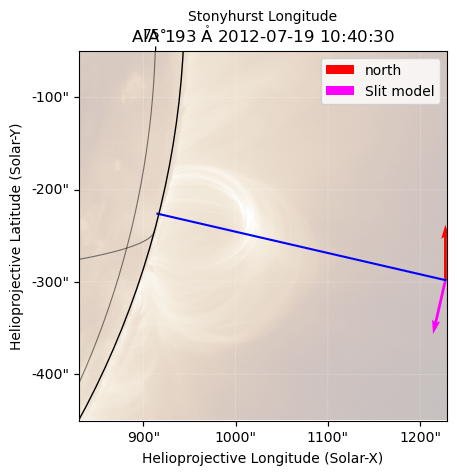

In [36]:
# Plot a map and display position of slit #2 (that is model derived ?)
blank_submap = crop_imag_to_roi(aia_193_imag)

# Initialize Sunpy map plto
fig = plt.figure()
ax = fig.add_subplot(projection=blank_submap)
blank_submap.plot(axes=ax, alpha=0.25)
blank_submap.draw_limb(axes=ax, color="k")
blank_submap.draw_grid(axes=ax, color="k")

# Coordinates for entire slit
slit_coords = SkyCoord(slit_info['x']*u.arcsec, slit_info['y']*u.arcsec, frame=blank_submap.coordinate_frame)

# Origin for slit vectors
ind = 1
init_coord = blank_submap.wcs.world_to_pixel(SkyCoord(slit_info['x'][ind]*u.arcsec, slit_info['y'][ind]*u.arcsec, frame=blank_submap.coordinate_frame))  
# North vector
ax.quiver(init_coord[0], init_coord[1], 0., 100., 
           angles='xy', scale_units='xy', scale=1, color='red', label='north')
# Normal Vector to slit coordinates
ax.quiver(init_coord[0], init_coord[1], 100*slit_norm_X, 100.*slit_norm_Y, 
           angles='xy', scale_units='xy', scale=1, color='magenta', label='Slit model')
# Plot slit coordinates
ax.plot_coord(slit_coords, '-', color='blue')
ax.legend()

In [37]:
# Determine vector corresponding to slit coordinates

# Load slit file... (that is used for the T.D. plot)
slit_new_file = Path('td_slit_upd_num_2.pickle')
with open(slit_new_file, 'rb') as handle:
    slit_info = pickle.load(handle)

#slit_info
import math

loc_angles = []
for idx, (x, y) in enumerate(zip(slit_info['x'], slit_info['y'])):
    if idx != 0:
        slope = (slit_info['y'][idx] - slit_info['y'][idx - 1]) / (slit_info['x'][idx] - slit_info['x'][idx - 1])
        angle_radians = math.atan(slope)
        angle_degrees = math.degrees(angle_radians)
        loc_angles.append(angle_degrees)
    # print(idx)

loc_angle = np.average(np.array(loc_angles))

slit_norm_angle = loc_angle - 90
slit_norm_X = np.cos(np.radians(slit_norm_angle))
slit_norm_Y = np.sin(np.radians(slit_norm_angle))

slit_norm_global = np.array([slit_norm_X, slit_norm_Y, 0.])

slit_norm_global

array([-0.16380284, -0.9864931 ,  0.        ])

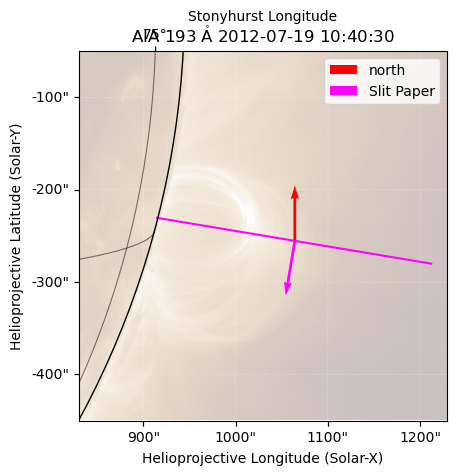

In [38]:
# Plot a map and display position of slit #2 (that is model derived ?)
blank_submap = crop_imag_to_roi(aia_193_imag)

# Initialize Sunpy map plto
fig = plt.figure()
ax = fig.add_subplot(projection=blank_submap)
blank_submap.plot(axes=ax, alpha=0.25)
blank_submap.draw_limb(axes=ax, color="k")
blank_submap.draw_grid(axes=ax, color="k")

# Coordinates for entire slit
slit_coords = SkyCoord(slit_info['x']*u.arcsec, slit_info['y']*u.arcsec, frame=blank_submap.coordinate_frame)

# Origin for slit vectors
ind = 100
init_coord = blank_submap.wcs.world_to_pixel(SkyCoord(slit_info['x'][ind]*u.arcsec, slit_info['y'][ind]*u.arcsec, frame=blank_submap.coordinate_frame))  
# North vector
ax.quiver(init_coord[0], init_coord[1], 0., 100., 
           angles='xy', scale_units='xy', scale=1, color='red', label='north')
# Normal Vector to slit coordinates
ax.quiver(init_coord[0], init_coord[1], 100*slit_norm_X, 100.*slit_norm_Y, 
           angles='xy', scale_units='xy', scale=1, color='magenta', label='Slit Paper')
# Plot slit coordinates
ax.plot_coord(slit_coords, '-', color='magenta')
ax.legend()

In [39]:
# load yt dataset to extract orientation to find angle between the slit plane and RCS
import yt
from yt.utilities.orientation import Orientation

dataset_file = '/home/gabriel/rad_transfer_/datacubes/subs_3_flarecs-id_0065.h5'
ds = yt.load(dataset_file, hint="YTGridDataset")

ds_orientation = Orientation(los_vec, north_vector=north_vec)
unit_vectors = ds_orientation.unit_vectors
los_vec, north_vec, unit_vectors

#slit_norm
#dir(ds_orientation)
ds_orientation.inv_mat

yt : [INFO     ] 2025-02-20 14:36:58,763 Parameters: current_time              = 6.500023 code_time
yt : [INFO     ] 2025-02-20 14:36:58,765 Parameters: domain_dimensions         = [193 192  96]
yt : [INFO     ] 2025-02-20 14:36:58,766 Parameters: domain_left_edge          = [-0.5   0.   -0.25] code_length
yt : [INFO     ] 2025-02-20 14:36:58,766 Parameters: domain_right_edge         = [0.50000016 0.99999994 0.24999997] code_length
yt : [INFO     ] 2025-02-20 14:36:58,767 Parameters: cosmological_simulation   = 0


unyt_array([[ 0.21569996,  0.97399661, -0.06931185],
            [ 0.97293478, -0.22040509, -0.06942268],
            [-0.08289414, -0.05246144, -0.99517655]], '(dimensionless)')

In [40]:
# Matrix multiplication of ds orientation and normal to slit

slit_norm_local = ds_orientation.inv_mat @ slit_norm_global
slit_norm_local

unyt_array([-0.9961732 ,  0.05805862,  0.06533115], '(dimensionless)')

yt : [INFO     ] 2025-02-20 14:36:59,308 Making a fixed resolution buffer of (('gas', 'velocity_y')) 120 by 120


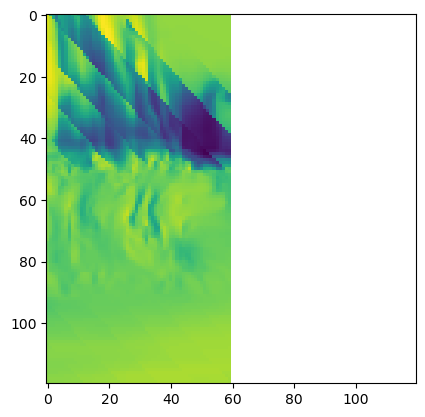

In [41]:
# Extract and plot slice of a dataset at given coordinate
slice_center_point = [0., 0.5, 0.25]

slit_plane_cut_local = ds.cutting(slit_norm_local, slice_center_point)
slc_frb = slit_plane_cut_local.to_frb((120, "Mm"), resolution=120)

local_vy = slc_frb[('gas', 'velocity_y')].d

fig, ax = plt.subplots()
ax.imshow(local_vy.T, origin='upper')

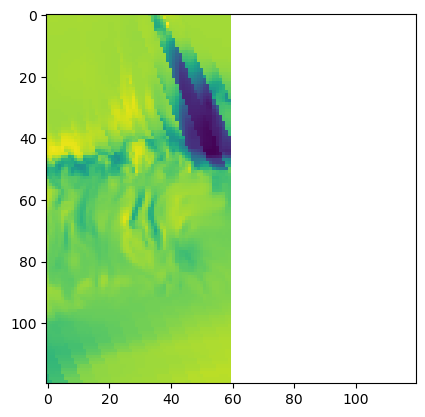

In [42]:
# Extract and plot slice of a dataset at given coordinate
slice_center_point = [0., 0.5, 0.25]

slit_plane_cut_local = ds.cutting([-0.95,0.06,0.15], slice_center_point)
slc_frb = slit_plane_cut_local.to_frb((120, "Mm"), resolution=120)

local_vy = slc_frb[('gas', 'velocity_y')].d

fig, ax = plt.subplots()
ax.imshow(local_vy.T, origin='upper')